# Cox regression and hazard ratio model

Cox fa analisi di ogni variabile data e predice per ognuna l'hazard ratio, ovvero una probabilità, che se >1 indica che il rischio dell'accadere dell'evento aumenta all'aumentare del valore di quella variabile (o presenza di quella variabile in caso di booleane), mentre diminuisce se l'hazard ratio è <1. 


Input : feature vectors con età del paziente alla diagnosi, last days to follow-up, evento morte booleano, miRNA-seq vector con valori normalizzati con log e quantile.

Pipeline:
   - Scaling con **Z-scaler** su campi di età e miRNA-seq
   - Applicazione di elsatic net tramite ```scikit-survival.CoxnetSurvivalAnalysis``` da addestrare (scikit-survival at: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html)
      - Applicare grid search e K-fold cross validation per capire set di parametri migliori
   - Calcolo di risk score con funzione di predict
        - possibile prevedere survival function o cumulative hazard function anche, ma necessario fare fine tuning con parametro ```fit_baselin_model=True```

Motivazioni:
   - Z-scaler per portare valori predittivi su stessa scala con varianza 1 e media 0
   - Utilizzo di Cox con penalizzazione per fare feature selection e selezionare solo miRNA con maggiore rilevanza
   - Utilizzo Elastic Net poichè Lasso-Cox normale non ottimale per due motivi: non può selezionare più features di quanti sample ci sono e in gruppo di features con alta correlazione tra loro ne sceglie a caso solo una tra queste. Elastic net risolve questi usando combinazione di l1 e l2 e rendendo più robusto

## Init

In [70]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json 

In [4]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

d:\Universita\2 anno magistrale\Progetto BioInf\miRNA_to_age


In [ ]:
# available datasets:
#   clinical_miRNA_normalized_log.csv
#   clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset_name = 'clinical_miRNA_normalized_quant.csv'
dataset = pd.read_csv(os.path.join(DATA_PATH, dataset_name))
dataset_type = dataset_name.split('\\')[-1][9:-4] if 'mRNA' in dataset_name else dataset_name[9:-4]

In [40]:
print(dataset.shape)
print(dataset.columns)
# print(dataset.head())
print(type(dataset.iloc[0]['days_to_death']))

(760, 9983)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB', 'pathologic_stage_Stage IIIA',
       'pathologic_stage_Stage IIIC',
       ...
       'gene.ELOA3D', 'gene.PDCD6-AHRR', 'gene.ELOA3', 'gene.AC013477.1',
       'gene.AC020765.6', 'gene.AC010980.1', 'gene.AC004233.4',
       'gene.AC008763.4', 'gene.AL391628.1', 'gene.AP006621.6'],
      dtype='object', length=9983)
<class 'numpy.float64'>


### Hyper-parameters

In [41]:
num_folds = 10
SEED = 42
use_clinical = True
dataset_type = 'clinical_'+dataset_type if use_clinical else 'seq_only'+dataset_type

## Data

In [42]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
if use_clinical:
    print('USING clinical data') 
    X_cols = [col for col in dataset.columns if col not in y_cols]
else:
    print('EXCLUDING clinical data') 
    miRNA_clinical_cols = [col for col in dataset.columns if col not in y_cols and 'hsa' not in col]
    mRNA_clinical_cols = [col for col in dataset.columns if col not in y_cols and 'gene.' not in col]
    X_cols = [col for col in dataset.columns if col not in y_cols and not col in miRNA_clinical_cols and col not in mRNA_clinical_cols]

custom_dtype = np.dtype([
    ('event', np.bool_),         # O 'bool'
    ('time', np.float64)      # O 'float'
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        tuple = (False, row['days_to_last_followup'].item())
        y.append(np.array(tuple, dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]


USING clinical data


## Z-scaling

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

genes_cols = [col for col in X.columns if 'hsa' in col or 'gene.' in col]
genes_cols.append('age_at_initial_pathologic_diagnosis')
scaled_X = pd.DataFrame(scaler.fit_transform(X[genes_cols]), columns=genes_cols)

X[genes_cols] = scaled_X


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\3413578619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[genes_cols] = scaled_X


## Data splitting

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## K-fold

In [45]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Elastic net (Lasso-Cox)

### Setup

In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
import warnings
from sklearn.exceptions import FitFailedWarning

In [47]:
def plot_coefficients(coefs):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    ax.legend(loc='best')

In [48]:
from sksurv.metrics import concordance_index_censored
def c_index_scorer(estimator, X, y):
    # Estrai i campi 'death' e 'days' da y
    event_indicator = y['event']
    event_time = y['time']
    # Predici i punteggi di rischio
    risk_scores = estimator.predict(X)
    # Calcola il concordance index
    c_index = concordance_index_censored(event_indicator, event_time, risk_scores)[0]
    return c_index

### Gridsearch for best paramters

In [68]:
def parse_array(x):
    if isinstance(x, str):
        x = x.strip('[]')
        return eval(x, {'np':np})
    

bp_path = os.path.join(ROOT, f"best_params\\{dataset_type}_bp.json")
alphas_path = os.path.join(ROOT, f"best_params\\{dataset_type}_alphas.csv")

if os.path.exists(bp_path):
    with open(bp_path, 'r') as f:
        best_params = json.load(f)
        
if os.path.exists(alphas_path):
    res = pd.read_csv(alphas_path)
    res['param_alphas'] = res['param_alphas'].apply(parse_array)

first random search for l1_ratio and alpha_min_ratio

In [26]:
cen = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.05)

gcv = GridSearchCV(
    cen,
    param_grid={
        "l1_ratio": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "alpha_min_ratio":[0.01, 0.05, 0.1]
    },
    cv=kfold,
    error_score=0.5,
    n_jobs=8,
).fit(X_train, y_train)

print(gcv.best_params_)
best_params['alpha_min_ratio'] = gcv.best_params_['alpha_min_ratio']
best_params['l1_ratio'] = gcv.best_params_['l1_ratio']

{'alpha_min_ratio': 0.1, 'l1_ratio': 0.9}


then extract estimated alphas

In [50]:
cen = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=best_params['l1_ratio'], alpha_min_ratio = best_params['alpha_min_ratio']))

# warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

cen.fit(X_train, y_train)
estimated_alphas = cen.named_steps["coxnetsurvivalanalysis"].alphas_

and perform another random search for alphas values

In [28]:
cen = CoxnetSurvivalAnalysis(**best_params)

rcv = RandomizedSearchCV(
    cen,
    param_distributions={
        "alphas":[[v] for v in map(float, estimated_alphas)]
    },
    cv=kfold,
    scoring=c_index_scorer,
    error_score=0.5,
    n_iter=30, # 30
    n_jobs=8,
    verbose=2,
    random_state=SEED
).fit(X_train, y_train)

print("\n\n")

res = pd.DataFrame(rcv.cv_results_)
print(rcv.best_params_)

best_params['alphas'] = rcv.best_params_['alphas']

# estimated time for miRNA: 18min
# estimated time for mRNA:  30min

Fitting 10 folds for each of 30 candidates, totalling 300 fits


KeyboardInterrupt: 

Selection of the best alpha as the one which leaves 20-30 coefficients not 0 and has the highest concordance index

In [56]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


elegible_models = []
min_cols_model = None
for i in range(len(res['param_alphas'])):
    print(f'Testing alpha {i}/{len(res['param_alphas'])}')
    cen = CoxnetSurvivalAnalysis(l1_ratio = best_params['l1_ratio'], alpha_min_ratio = best_params['alpha_min_ratio'], alphas=[res['param_alphas'][i]], max_iter=100000)
    
    try:
        cen.fit(X_train, y_train)
    except Exception as e:
        if isinstance(e, ArithmeticError):
            print("ArithmeticError occurred")
            continue
        else:
            print(e)
            continue

    non0_coefs = len(cen.coef_[cen.coef_ != 0])
    if min_cols_model is None or (non0_coefs > 20 and non0_coefs < min_cols_model['num_coefs']):
        min_cols_model={
            'model':cen,
            'num_coefs':non0_coefs,
            'alpha':res['param_alphas'][i],
            'score':res['mean_test_score'][i]
        }

    if non0_coefs > 20 and non0_coefs <=40:
        elegible_models.append({
            'model':cen,
            'num_coefs':non0_coefs,
            'alpha':res['param_alphas'][i],
            'score':res['mean_test_score'][i]
        })
    
    if len(elegible_models) != 0:
        best_model = elegible_models[0]
        for model in elegible_models:
            if model != best_model and model['score'] > best_model['score']:
                best_model = model
    else:
        best_model = min_cols_model

print(best_model)

Testing alpha 0/30
ArithmeticError occurred
Testing alpha 1/30
Testing alpha 2/30
Testing alpha 3/30
Testing alpha 4/30
Testing alpha 5/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 6/30
Testing alpha 7/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


ArithmeticError occurred
Testing alpha 8/30
Testing alpha 9/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)
C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 10/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)
C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 11/30
Testing alpha 12/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  cen.fit(X_train, y_train)
C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 13/30
Testing alpha 14/30
ArithmeticError occurred
Testing alpha 15/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 16/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  cen.fit(X_train, y_train)


Testing alpha 17/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  cen.fit(X_train, y_train)
C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 18/30
Testing alpha 19/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 20/30
Testing alpha 21/30
ArithmeticError occurred
Testing alpha 22/30
Testing alpha 23/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)
C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 24/30
Testing alpha 25/30
Testing alpha 26/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)
C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 27/30
ArithmeticError occurred
Testing alpha 28/30


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen.fit(X_train, y_train)


Testing alpha 29/30
{'model': CoxnetSurvivalAnalysis(alpha_min_ratio=0.01,
                       alphas=[np.float64(0.09636065806844991)], l1_ratio=0.3), 'num_coefs': 52, 'alpha': np.float64(0.09636065806844991), 'score': np.float64(0.5957390969213698)}


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_6560\829290902.py:8: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  cen.fit(X_train, y_train)


In [63]:
best_model['alpha']

np.float64(0.09636065806844991)

Saving best parameters into a file

In [ ]:
bp_path = os.path.join(ROOT, f"best_params\\{dataset_type}_bp.json")
alphas_path = os.path.join(ROOT, f"best_params\\{dataset_type}_alphas.csv")

if not os.path.exists(bp_path):
    best_params = gcv.best_params_ | {'alphas':[best_model['alpha']]}
    with open(os.path.join(ROOT, f"best_params\\{dataset_type}_bp.json"), 'w') as f:
        json.dump(best_params, f)

if not os.path.exists(alphas_path):
    res.to_csv(alphas_path, index=False)

plot of concordance index wrt alpha values

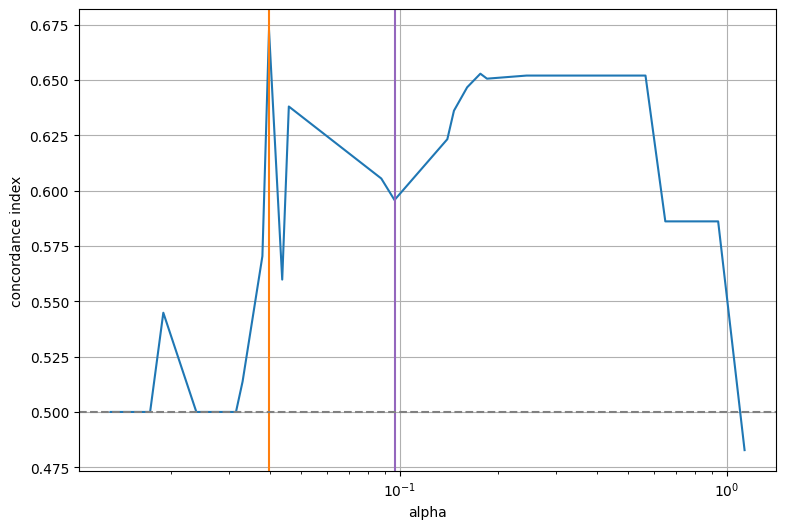

In [58]:
# alphas = res['param_alphas'].sort_values()
alphas = res['param_alphas']#.apply(lambda x: x[0])
mean = res.mean_test_score
std = res.std_test_score

df = pd.DataFrame(data={'alphas':alphas, 'mean':mean, 'std':std})
df = df.sort_values(by='alphas')

alphas = df['alphas']
mean = df['mean']
std=df['std']

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
# ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(best_params["alphas"][0], c="C1")
ax.axvline(best_model['alpha'], c='C4')
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

plot of mean test concordance-index

{'whiskers': [<matplotlib.lines.Line2D at 0x1e478edbe30>,
 'caps': [<matplotlib.lines.Line2D at 0x1e478e864b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e478edbb30>],
 'medians': [<matplotlib.lines.Line2D at 0x1e478e3b7a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e460e0c4a0>],
 'means': []}

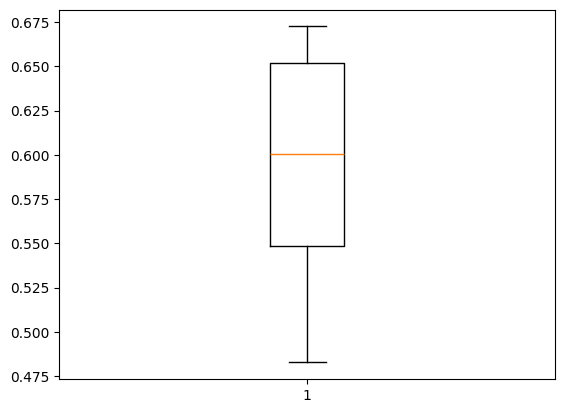

In [59]:
plt.boxplot(res['mean_test_score'])

In [69]:
# cen_best = CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['alpha_min_ratio'], l1_ratio=best_params['l1_ratio'], alphas=[best_model['alpha']], max_iter=100000)# for predicting just the risk score
cen_best = CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['alpha_min_ratio'], l1_ratio=best_params['l1_ratio'], alphas=best_params['alphas'], max_iter=100000)#  #for predicting just the risk score
cen_best.fit(X_train, y_train)
print("\nFinished training cen_best\n")

pred_res = cen_best.predict(X_test)
c_index = c_index_scorer(cen_best, X_test, y_test)
print(f"Test c-index: {c_index}")

best_vars = X_train.columns[np.where(cen_best.coef_ != 0)[0]]
print(f"Kept {len(best_vars)} variables for infer\n")

print("Beginning cross validation on test")
cv = cross_val_score(cen_best, X, y, cv=kfold, scoring=c_index_scorer)
print(f"Cross validation scores: {cv}")
print(f"Cross validation average: {cv.sum()/len(cv)}")


Finished training cen_best

Test c-index: 0.6308539944903582
Kept 52 variables for infer

Beginning cross validation on test
Cross validation scores: [0.70652174 0.54037267 0.53508772 0.64069264 0.55434783 0.70652174
 0.39189189 0.69142857 0.75409836 0.56896552]
Cross validation average: 0.6089928676363746


In [67]:
X_train.columns[np.where(cen_best.coef_ != 0)[0]]

Index(['gene.MYH13', 'gene.MATK', 'gene.SNAP91', 'gene.CPT1A', 'gene.TNP1',
       'gene.NPY', 'gene.NFE2', 'gene.RAC2', 'gene.CCNA1', 'gene.MRO',
       'gene.GRHL1', 'gene.ADAMTS8', 'gene.SLC25A47', 'gene.GTF2H2',
       'gene.SLC16A2', 'gene.ZIC3', 'gene.SUSD3', 'gene.ICA1L', 'gene.NPY1R',
       'gene.ADAM9', 'gene.UGT3A2', 'gene.NSG1', 'gene.VCX3A', 'gene.PCSK9',
       'gene.BOLA2B', 'gene.HOXD12', 'gene.ANKK1', 'gene.CEL', 'gene.SHCBP1',
       'gene.ARPP21', 'gene.LONRF3', 'gene.ALX1', 'gene.DEFB119', 'gene.GSX2',
       'gene.H2AW', 'gene.SHISAL2A', 'gene.TNFRSF18', 'gene.SAMD7',
       'gene.H2BU1', 'gene.KEL', 'gene.PEG3', 'gene.C1orf68', 'gene.HTN3',
       'gene.LRRC30', 'gene.OR6B1', 'gene.RFPL4AL1', 'gene.KIAA1210',
       'gene.AC023055.1', 'gene.AL139011.2', 'gene.ZIM2', 'gene.FAM95C',
       'gene.AC132217.2'],
      dtype='object')

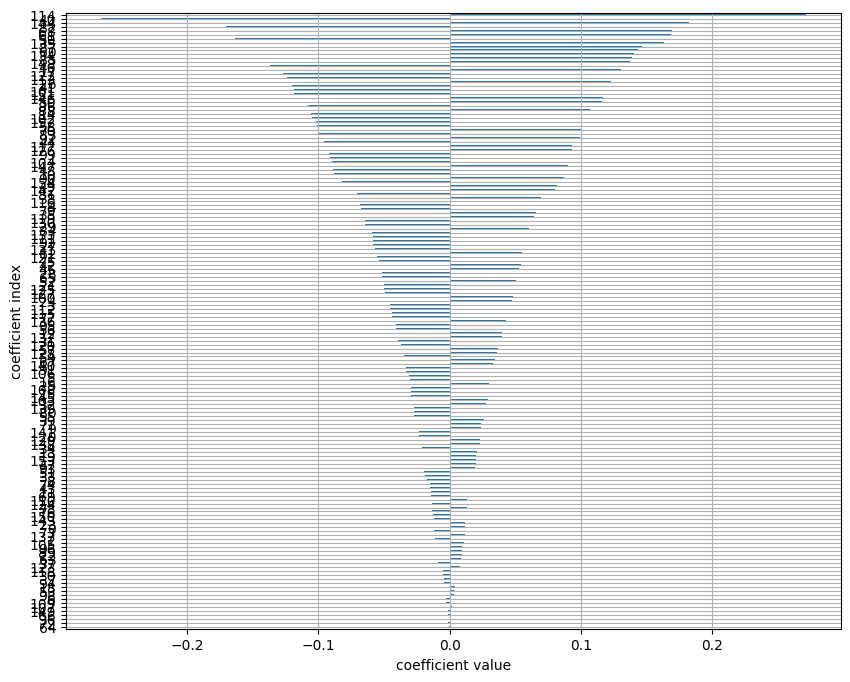

In [64]:
values = cen_best.coef_[cen_best.coef_ != 0]
coefs = X.columns[np.where(cen_best.coef_ != 0)[0]]

df = pd.DataFrame({"coefs":coefs, "values":values})
df = df.sort_values(by='values', key=abs, ascending=True)

_, ax = plt.subplots(figsize=(10, 8))
df.plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient value')
ax.set_ylabel('coefficient index')
ax.grid(True)


In [29]:
cen_best_for_func = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[best_model['alpha']], fit_baseline_model=True, max_iter=100000)) # to predict the hazard function
cen_best_for_func.fit(X_train, y_train)
print("Finished training cen_best_for_func")

Finished training cen_best_for_func
